In [1]:
import pandas as pd
all_internationals = 'C:/Users/killi/OneDrive/Desktop/Kaggle_results_rugby/all_internationals.csv'
all_internationals_df = pd.read_csv(all_internationals)

Pacific_nations = 'C:/Users/killi/OneDrive/Desktop/Kaggle_results_rugby/Pacific_nations.csv'
Autumn_internationals = 'C:/Users/killi/OneDrive/Desktop/Kaggle_results_rugby/Autumn_internationals.csv'

Pacific_nations_df = pd.read_csv(Pacific_nations)
Autumn_internationals_df = pd.read_csv(Autumn_internationals)

# Ensure your date column is in datetime format
all_internationals_df['date'] = pd.to_datetime(all_internationals_df['date'])

# Filter for dates from January 1, 2024, onwards
filtered_2024 = all_internationals_df[all_internationals_df['date'] >= '2024-01-01']

Pacific_autumn = pd.concat([Pacific_nations_df, Autumn_internationals_df]).reset_index(drop=True)

# Rename specific columns
Pacific_autumn = Pacific_autumn.rename(columns={
    'Date': 'date',
    'Home Team': 'home_team',
    'Away Team': 'away_team',
    'Home Score':'home_score',
    'Away Score':'away_score'
})

# Ensure your date column is in datetime format
Pacific_autumn['date'] = pd.to_datetime(Pacific_autumn['date'])

filtered_2024 = filtered_2024[['date','home_team','away_team','home_score','away_score']]

# Combine all data
all_2024 = pd.concat([filtered_2024, Pacific_autumn]).reset_index(drop=True)


import numpy as np

home_teams = all_2024['home_team'].unique()
away_teams = all_2024['away_team'].unique()

# Concatenate the arrays and keep unique values
unique_teams = np.unique(np.concatenate((home_teams, away_teams)))

# get number of teams
n_teams = len(unique_teams)


# Define the mapping
team_mapping = {'Argentina': 0, 'Australia': 1,
                'Canada': 2, 'England': 3, 'Fiji': 4, 'France': 5,
       'Georgia': 6, 'Ireland': 7, 'Italy': 8,
                'Japan': 9, 'New Zealand': 10, 'Portugal': 11,
       'Samoa': 12, 'Scotland': 13, 'South Africa': 14, 'Spain': 15, 'Tonga': 16, 'USA': 17,
       'Uruguay': 18, 'Wales': 19}

# Reverse the mapping for easier lookup of team names by index
index_to_team = {v: k for k, v in team_mapping.items()}

# Map the categories to numbers
all_2024['home_num'] = all_2024['home_team'].map(team_mapping)
all_2024['away_num'] = all_2024['away_team'].map(team_mapping)

# Create arrays to be used by PYMC
home_score_arr = all_2024['home_score'].values
away_score_arr = all_2024['away_score'].values
home_team = all_2024['home_num'].values
away_team = all_2024['away_num'].values

# Group by 'group_column' and compute the mean of 'value_column1'
home_mean = all_2024.groupby('home_team')['home_score'].mean()
home_mean = home_mean.sort_values(ascending=False)
home_mean.to_csv('home_mean.csv')

away_mean = all_2024.groupby('away_team')['away_score'].mean()
away_mean = away_mean.sort_values(ascending=False)
away_mean.to_csv('away_mean.csv')

C:\Users\killi\AppData\Local\Temp\ipykernel_19976\169180359.py:29: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  Pacific_autumn['date'] = pd.to_datetime(Pacific_autumn['date'])


In [2]:
# Below model links home and away parameters to sigma and mean

import pymc as pm

# Create Model
with pm.Model() as model:
    home = pm.Normal("home", 0, 0.5)

    # Attack ratings for teams - common mu and sd that all teams draw from
    atts_mu = pm.Normal("atts_mu", 0, 0.5)
    atts_sd = pm.HalfNormal("atts_sd", 0.5)
    atts = pm.Normal("atts", mu=atts_mu, sigma=atts_sd, shape=n_teams)

    # Defence ratings for teams - common mu and sd that all teams draw from
    defs_mu = pm.Normal("defs_mu", 0, 0.5)
    defs_sd = pm.HalfNormal("defs_sd", 0.5)
    defs = pm.Normal("defs", mu=defs_mu, sigma=defs_sd, shape=n_teams)

    # Calculate theta

    # Register away_theta and home_theta as a deterministic variable
    home_theta = pm.Deterministic("home_theta", pm.math.exp(home + atts[home_team] + defs[away_team]))
    away_theta = pm.Deterministic("away_theta", pm.math.exp(atts[away_team] + defs[home_team]))


    # Create standard deviations for Home points and away points
    sigma_home_points = pm.HalfNormal("sigma_home_points",10)
    sigma_away_points = pm.HalfNormal("sigma_away_points",10)


    # Truncated Normal for observed scores
    home_points = pm.Truncated(
        "home_points",
        pm.Normal.dist(mu=home_theta, sigma=sigma_home_points),
        lower=0,
        observed=home_score_arr,
    )
    away_points = pm.Truncated(
        "away_points",
        pm.Normal.dist(mu=away_theta, sigma=sigma_away_points),
        lower=0,
        observed=away_score_arr,
    )
    
    # Get prior samples
    prior_samples = pm.sample_prior_predictive(1000)


Sampling: [atts, atts_mu, atts_sd, away_points, defs, defs_mu, defs_sd, home, home_points, sigma_away_points, sigma_home_points]


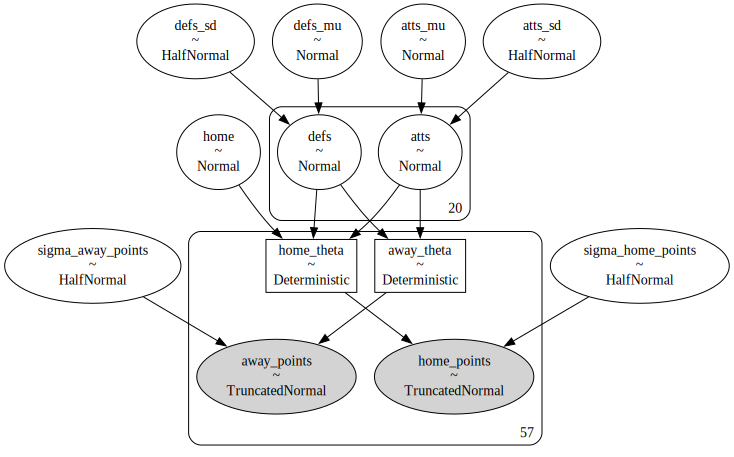

In [3]:
# Graph Model
# I think sigma away points should be in the atts box
pm.model_to_graphviz(model)

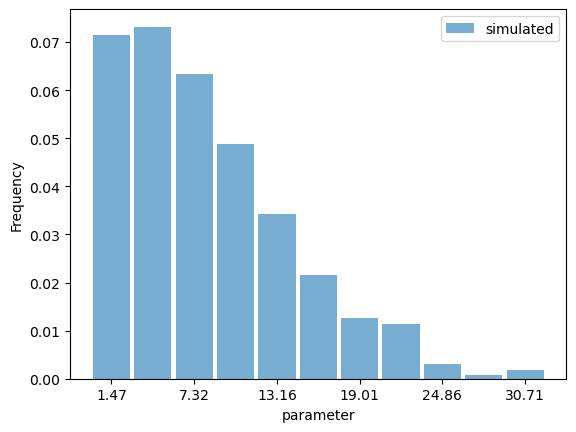

In [9]:
import arviz as az
import matplotlib.pyplot as plt

# Try plot graph of individual variables
# Plot simulated values for first observation
az.plot_dist(
    prior_samples.prior['sigma_home_points'].values,
    kind="hist",
    hist_kwargs={"alpha": 0.6},
    label="simulated",
)

# Reduce the number of x-axis labels
plt.xticks(ticks=plt.gca().get_xticks()[::2])  # Keep every other tick (adjust indexing as needed)

# Add labels and legend if needed
plt.xlabel("parameter")
plt.ylabel("Frequency")
plt.legend()
plt.show()




<Axes: >

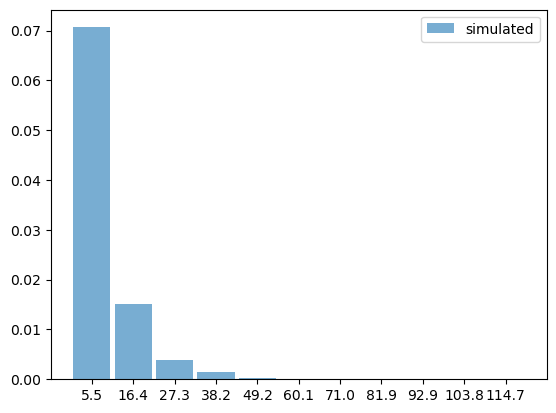

In [10]:
az.plot_dist(
    prior_samples.prior_predictive["home_points"][:,:,0].values,
    kind="hist",
    hist_kwargs={"alpha": 0.6},
    label="simulated",
)

In [11]:
# Create Model
with model:
    trace = pm.sample(1000, tune=2000, cores=4, random_seed=52, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, atts_mu, atts_sd, atts, defs_mu, defs_sd, defs, sigma_home_points, sigma_away_points]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 102 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.


In [12]:
# Get summary of trace
# Priors seem to be quite strong

import arviz as az

# Generate the summary of the posterior
summary_df = az.summary(trace.posterior, round_to=2)

# filter for columns
summary_df = summary_df[['mean','sd','hdi_3%','hdi_97%','r_hat']]

# Add in teams
def replace_index_with_team_name(index, mapping):
    # Match patterns like "atts[0]" or "defs[0]" and replace "0" with the team name
    if index.startswith("atts[") or index.startswith("defs["):
        # Extract the parameter type (e.g., "atts" or "defs") and the team index
        param_type = index.split("[")[0]
        team_index = int(index.split("[")[1].strip("]"))  # Extract the number inside brackets
        
        # Find the corresponding team name from the mapping
        for team, num in mapping.items():
            if num == team_index:
                return f"{param_type}[{team}]"
    return index  # Leave other rows unchanged

summary_df = summary_df.rename(index=lambda x: replace_index_with_team_name(x, team_mapping))

# Save as csv
summary_df.to_csv('summary_df.csv')

# Display the updated DataFrame
print(summary_df)

                  mean    sd  hdi_3%  hdi_97%  r_hat
home              0.11  0.17   -0.15     0.39   1.00
atts_mu           1.49  0.38    0.85     2.20   1.12
atts[Argentina]   1.67  0.44    0.87     2.46   1.10
atts[Australia]   1.64  0.43    0.83     2.41   1.10
atts[Canada]      1.29  0.42    0.52     2.06   1.08
...                ...   ...     ...      ...    ...
away_theta[52]   24.86  5.64   13.72    35.05   1.00
away_theta[53]   22.84  5.61   12.09    33.02   1.01
away_theta[54]   20.60  5.86    9.24    31.09   1.00
away_theta[55]   28.88  7.10   15.65    42.83   1.00
away_theta[56]   21.76  5.11   11.71    30.81   1.00

[161 rows x 5 columns]


In [17]:
np.exp(0.11)

1.1162780704588713

In [18]:
np.exp(1.67)

5.312167797181167

In [26]:
np.exp(1.6 + 1.6 + 0.11)

27.38512547190322

home score mean:  26.56140350877193
home score std:  11.13713173547485


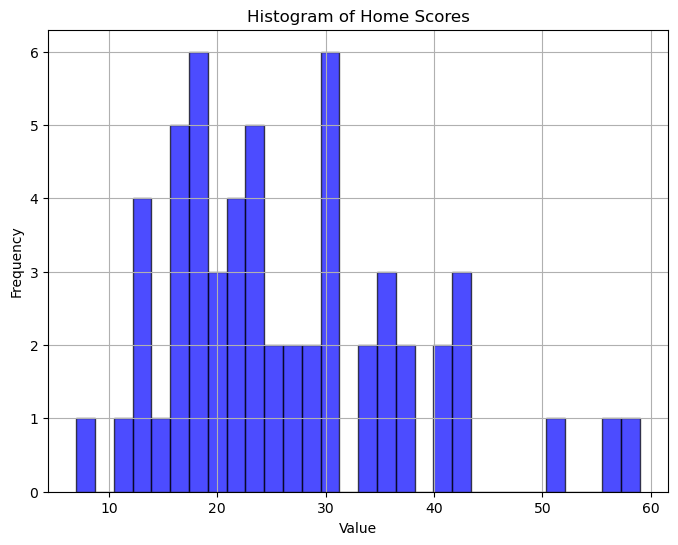

home score mean:  25.68421052631579
home score std:  13.135138216085839


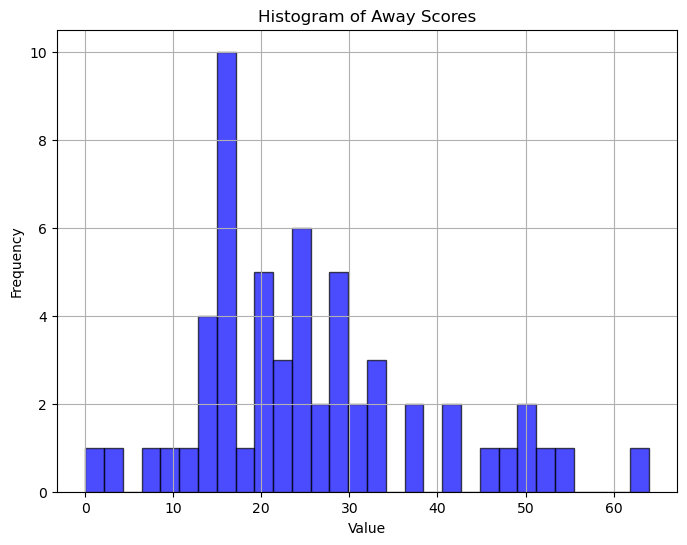

In [27]:
# Plot Home Scores
import numpy as np
import matplotlib.pyplot as plt

# get statistics
print('home score mean: ',np.mean(home_score_arr))
print('home score std: ',np.std(home_score_arr))

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(home_score_arr, bins=30, alpha=0.7, color="blue", edgecolor="black")

# Add labels and title
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Home Scores")
plt.grid(True)
plt.show()


# Plot Away Scores
import numpy as np
import matplotlib.pyplot as plt

# get statistics
print('home score mean: ',np.mean(away_score_arr))
print('home score std: ',np.std(away_score_arr))

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(away_score_arr, bins=30, alpha=0.7, color="blue", edgecolor="black")

# Add labels and title
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Away Scores")
plt.grid(True)
plt.show()




<Axes: >

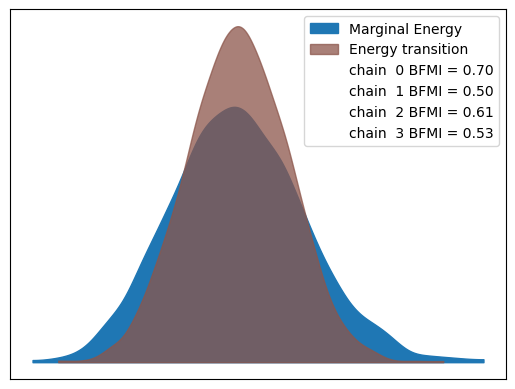

In [13]:
# Unsure what this plot is
# Distributions are not similar so must be something wrong
# This seems the best one so far
az.plot_energy(trace)

array([[<Axes: title={'center': 'atts_mu'}>,
        <Axes: title={'center': 'atts_mu'}>]], dtype=object)

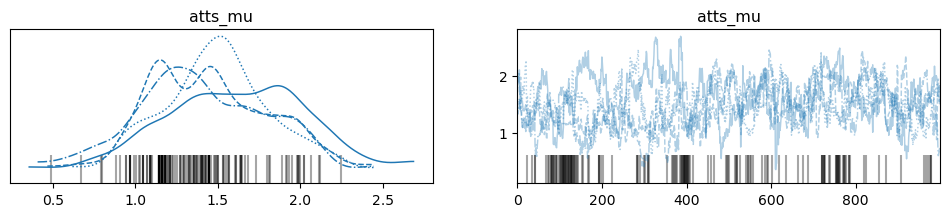

In [14]:
# Plot doesn't look like it has converged
az.plot_trace(trace, var_names=["atts_mu"])

In [28]:
# Think the next step is to generate scores from the model

# Get sample posterior predictive
with model:
    post_samples = pm.sample_posterior_predictive(trace,extend_inferencedata=True)



Sampling: [away_points, home_points]


In [29]:
# Had to run this code first before plot ppc
pm.sample_posterior_predictive(trace, model=model, extend_inferencedata=True)

Sampling: [away_points, home_points]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

C:\Users\killi\anaconda3\envs\pymc5\Lib\site-packages\arviz\plots\ppcplot.py:268: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
C:\Users\killi\anaconda3\envs\pymc5\Lib\site-packages\arviz\plots\ppcplot.py:272: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


array([<Axes: xlabel='home_points / home_points'>,
       <Axes: xlabel='away_points / away_points'>], dtype=object)

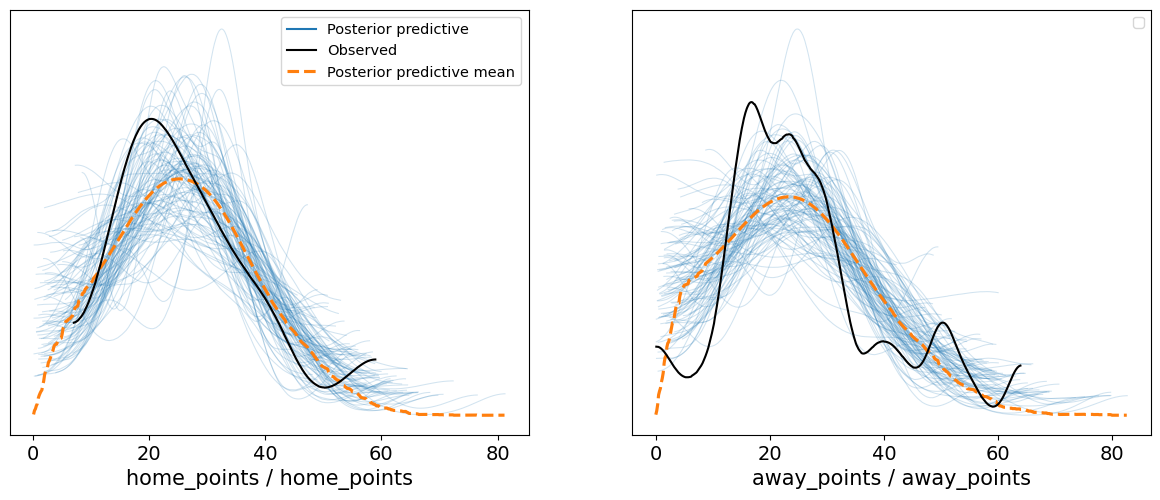

In [30]:
# Plot Posterior Predictive check
# Think this means that the normal distribution doesn't fit away points
# Could remove those points as outliers
# Mean is shifted to the right
# Could check standard dev - does it fall outside 2 or 3 standard devs
# or lower or above 1.5 IQR (75% I think) or 25%
# Could also replace Normal distribution with Student t - more weight in the tails


az.plot_ppc(trace, num_pp_samples=100)

In [32]:
home_data = post_samples.posterior_predictive['home_points']

# Initialize a list to store results
home_results = []

for i in range(57):
    p2_5 = np.percentile(home_data[:,:,i], 2.5)
    p16 = np.percentile(home_data[:,:,i], 16)
    p25 = np.percentile(home_data[:,:,i], 25)
    p50 = np.percentile(home_data[:,:,i], 50)
    mean = np.mean(home_data[:,:,i]).values
    std = np.std(home_data[:,:,i]).values
    p75 = np.percentile(home_data[:,:,i], 75)
    p84 = np.percentile(home_data[:,:,i], 84)
    p97_5 = np.percentile(home_data[:,:,i], 97.5)

    # Append the results as a dictionary
    home_results.append({"p2_5":p2_5,"p16":p16,"p25":p25,"p50":p50, "Mean": mean,"std":std, "p75": p75, "p84": p84,"p97_5": p97_5})
    

# Convert the results to a DataFrame
home_points_df = pd.DataFrame(home_results)

In [34]:
away_data = post_samples.posterior_predictive['away_points']

# Initialize a list to store results
away_results = []

for i in range(57):
    p2_5 = np.percentile(away_data[:,:,i], 2.5)
    p16 = np.percentile(away_data[:,:,i], 16)
    p25 = np.percentile(away_data[:,:,i], 25)
    p50 = np.percentile(away_data[:,:,i], 50)
    mean = np.mean(away_data[:,:,i]).values
    std = np.std(away_data[:,:,i]).values
    p75 = np.percentile(away_data[:,:,i], 75)
    p84 = np.percentile(away_data[:,:,i], 84)
    p97_5 = np.percentile(away_data[:,:,i], 97.5)

    # Append the results as a dictionary
    away_results.append({"p2_5":p2_5,"p16":p16,"p25":p25,"p50":p50, "Mean": mean,"std":std, "p75": p75, "p84": p84,"p97_5": p97_5})
    

# Convert the results to a DataFrame
away_points_df = pd.DataFrame(away_results)

In [114]:
# Combine chain and draw data into 1 sample and round to integers
away_draw_chains =  np.round(az.extract(away_data).away_points.values)
home_draw_chains = np.round(az.extract(home_data).home_points.values)

# Perform element-wise comparisons for all columns
home_win = np.sum(home_draw_chains > away_draw_chains, axis=1) 
away_win = np.sum(home_draw_chains < away_draw_chains, axis=1)  
draw = np.sum(home_draw_chains == away_draw_chains, axis=1)  

# Calculate percentages
total_comparisons = home_draw_chains.shape[1]
percent_home_win = (home_win / total_comparisons) * 100
percent_away_win = (away_win / total_comparisons) * 100
percent_draw = (draw / total_comparisons) * 100

# Create a summary DataFrame
summary_stats = pd.DataFrame({
    "Home Win (%)": percent_home_win,
    "Away Win (%)": percent_away_win,
    "Draw (%)": percent_draw,
})

# Display the summary DataFrame
#print(summary_stats)


In [117]:

# Merge actual back to sim for home
join_home = pd.merge(home_points_df,all_2024[['home_team','home_score']],left_index=True, right_index=True)

join_home['Mean'] = join_home['Mean'].astype(float)

# Round to 2 decimal places
join_home = join_home.round(2)

# create flag columns
join_home['95_flag'] = join_home.apply(lambda row: 1 if row['p2_5'] <= row['home_score'] <= row['p97_5'] else 0,axis=1)
join_home['68_flag'] = join_home.apply(lambda row: 1 if row['p16'] <= row['home_score'] <= row['p84'] else 0,axis=1)
join_home['50_flag'] = join_home.apply(lambda row: 1 if row['p25'] <= row['home_score'] <= row['p75'] else 0,axis=1)


# Select new columns
join_home = join_home[['home_team','home_score','Mean','std','95_flag','68_flag','50_flag']]

# Get rates
print('95% rate: ',round(join_home['95_flag'].sum()/join_home['95_flag'].count(),2))
print('68% rate: ',round(join_home['68_flag'].sum()/join_home['68_flag'].count(),2))
print('50% rate: ',round(join_home['50_flag'].sum()/join_home['50_flag'].count(),2))


# Merge actual back to sim for away
join_away = pd.merge(away_points_df,all_2024[['away_team','away_score']],left_index=True, right_index=True)

join_away['Mean'] = join_away['Mean'].astype(float)

# Round to 2 decimal places
join_away = join_away.round(2)


# create flag columns
join_away['95_flag'] = join_away.apply(lambda row: 1 if row['p2_5'] <= row['away_score'] <= row['p97_5'] else 0,axis=1)
join_away['68_flag'] = join_away.apply(lambda row: 1 if row['p16'] <= row['away_score'] <= row['p84'] else 0,axis=1)
join_away['50_flag'] = join_away.apply(lambda row: 1 if row['p25'] <= row['away_score'] <= row['p75'] else 0,axis=1)

# Select new columns
join_away = join_away[['away_team','away_score','Mean','std','95_flag','68_flag','50_flag']]

# Get rates
print('95% rate: ',round(join_away['95_flag'].sum()/join_away['95_flag'].count(),2))
print('68% rate: ',round(join_away['68_flag'].sum()/join_away['68_flag'].count(),2))
print('50% rate: ',round(join_away['50_flag'].sum()/join_away['50_flag'].count(),2))


# Merge actual back to sim for away
join_all_flags = pd.merge(join_home, join_away,left_index=True, right_index=True)

join_all_flags = join_all_flags[['home_team', 'home_score', 
                                 'away_team', 'away_score',
                                 'Mean_x','std_x', '95_flag_x', '68_flag_x',
       '50_flag_x',  'Mean_y','std_y', '95_flag_y',
       '68_flag_y', '50_flag_y']]

# calculate residuals
# Originally avg 8.66 home, 10.66 away
# New model slightly better 8.55 home and 10.65 away
# Down to 7.78 and 9.8 - could be the sim

join_all_flags['home_resid'] = join_all_flags['home_score'] - join_all_flags['Mean_x']
join_all_flags['away_resid'] = join_all_flags['away_score'] - join_all_flags['Mean_y']

# Create absolute column
join_all_flags['home_resid_abs'] = join_all_flags['home_resid'].abs()
join_all_flags['away_resid_abs'] = join_all_flags['away_resid'].abs()

home_rmse = np.sqrt(np.mean((join_all_flags['home_resid']) ** 2))
away_rmse = np.sqrt(np.mean((join_all_flags['away_resid']) ** 2))

print('home_rmse: ',home_rmse)
print('away_rmse: ',away_rmse)

# Originally 39%, this increased to 41%
# R squared also increased to 51%
from sklearn.metrics import r2_score

# Compare observed and predicted data
r2 = r2_score(join_all_flags['home_score'].values, join_all_flags['Mean_x'].values)
print(f"R-squared: {r2}")

# Join summary stats
join_percentages = pd.merge(join_all_flags,summary_stats,left_index=True,right_index=True)




95% rate:  0.98
68% rate:  0.89
50% rate:  0.65
95% rate:  0.98
68% rate:  0.81
50% rate:  0.61
home_rmse:  7.81237558497425
away_rmse:  9.79208747882608
R-squared: 0.5079383543593918


In [119]:
# This is good for analysing residuals and seeing where prediction went wrong
# Think sd for all teams is too restrictive
join_percentages.to_csv('join_percentages_1.csv')

In [ ]:
# My Mean is dependent on 3 factors
# Home advance, home team, away team
# Sigma is the same for all teams playing at home
# Sigma is the same for all teams playing away
# I may not have added the home factor in correctly

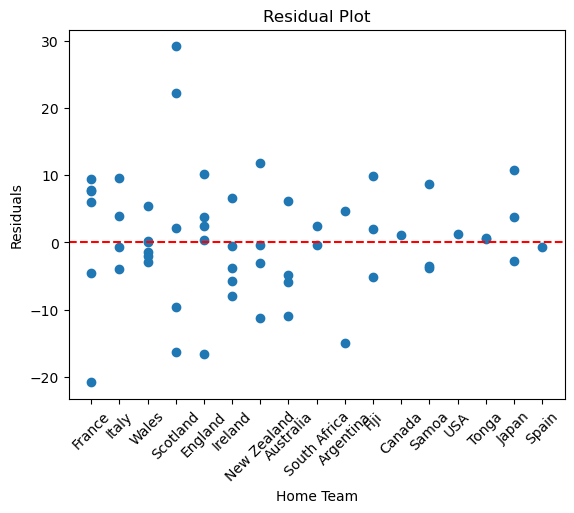

In [102]:
# Plot residuals for home score
import matplotlib.pyplot as plt

plt.scatter(join_all_flags['home_team'], join_all_flags['home_resid'].values)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Home Team")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Next steps
# Look at other ways that you can incorporate mean and sd together
# Look at the penguin example from the book
# We know the rmse is 8 points out for Home - how do we know if this is acceptable
# Need to test on holdout data and check the rmse
# Then what other factors could you add in
# Missing Players - Outhalf, scrum half
# Weather
